In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

import cv2
import pandas as pd
import ot
import ot.plot
import time
import numpy.linalg as la
import networkx as nx
import math
#from pointcloud_utils import vox_to_pointcloud
#import pointcloud_utils
from sklearn import manifold as man
# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

In [3]:
# Define the conversion functions
def vox_to_pointcloud(voxarray, grid, eps=0):
     
    xx, yy = np.squeeze(np.split(grid, 2))
    X = np.vstack((xx.ravel(), yy.ravel())).T
    nX = X.shape[0]
    nvi, nvj  = voxarray.shape
    if nX != nvi * nvj : raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X, voxarray.ravel().reshape(nvi * nvj, 1)), axis=1)
    return X[X[:, 2] > eps, :]

def pointcloud_to_vox(array, grid):
    xx, yy  = np.squeeze(np.split(grid, 2))
    points = array[:, 0:2]
    values = array[:, 2]
    interp = LinearNDInterpolator(points, values, fill_value=0.0)
    X = interp(xx, yy).T
    return X


In [4]:
def vox_to_pointcloud(voxarray,grid,eps=0):
    # Convert a voxel representation ('voxarray') to a (weighted) point cloud representation
    # Assume that the input grid is in "ij meshgrid" format i.e. the grid has two layers, xx and yy, each size (nx)-by-(ny)
    # The voxel array will be unrolled via "column-major" order ("Fortran/Matlab" ordering)
    # Note that initially the number of voxels must equal the number of grid points - but
    # zero voxels will be removed from the representation (i.e. no points with weight zero allowed)
    # if the optional parameter eps is passed, voxels with value less or equal to eps will be dropped
    # The returned array consists of (x,y,w) tuples i.e. X = [x1,y1,w1;x2,y2,w2;...;xP,yP,wP] where P
    # is the number of nonzero points
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    print(X.shape)
    print(voxarray.T.shape)
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]


def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))

    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

(12, 2)
(3, 4)


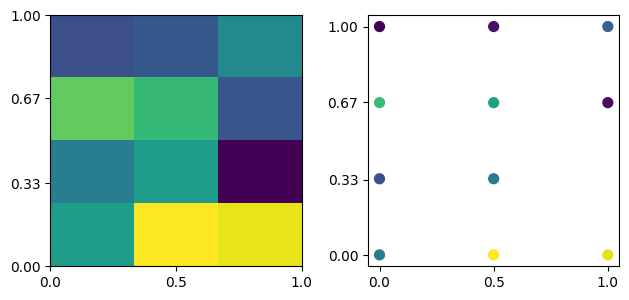

In [3]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

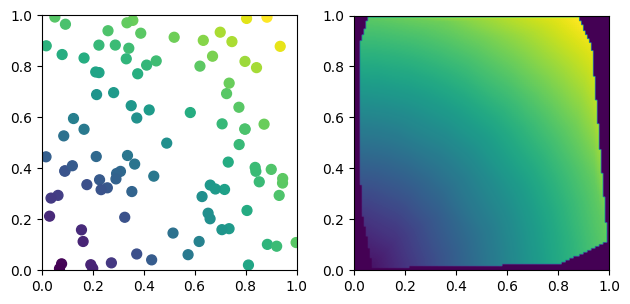

In [4]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

In [5]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

In [6]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

grid shape (2, 224, 224)
(50176, 2)
(224, 224)


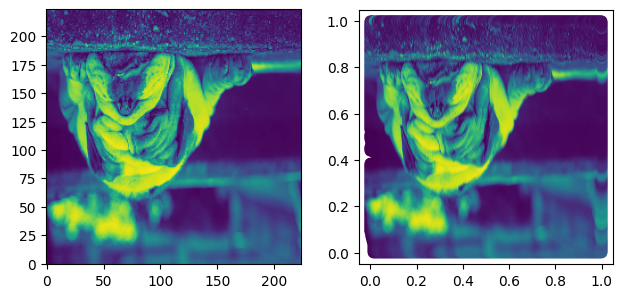

In [5]:
nxg = 224
nyg = 224
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud

def load_image_from_file(path):
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (nxg, nyg))
    return image
    
path = "/Users/thienphuong/Desktop/DATA-4381-Capstone-Project/dog-breeds/bulldog/bulldog10.jpg"
voxarray = load_image_from_file(path)
X = vox_to_pointcloud(voxarray, grid)


# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

In [10]:
path = "/Users/thienphuong/Desktop/DATA-4381-Capstone-Project/dog-breeds/bulldog/bulldog10.jpg"
voxarray = load_image_from_file(path)
X = vox_to_pointcloud(voxarray, grid)

(50176, 2)
(224, 224)


In [16]:
x = np.linspace(0,1,voxarray.shape[1])
y = np.linspace(0,1,voxarray.shape[0])
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)

grid shape (2, 510, 339)


grid shape (2, 510, 339)
(172890, 2)
(510, 339)


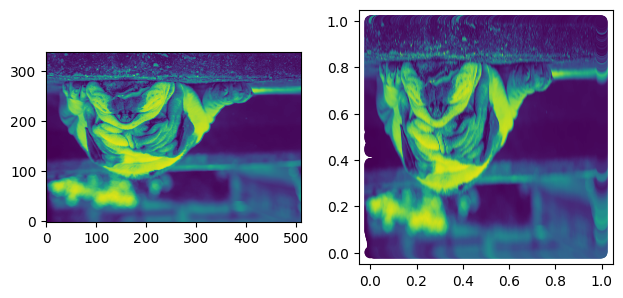

In [17]:
x = np.linspace(0,1,voxarray.shape[1])
y = np.linspace(0,1,voxarray.shape[0])
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud

def load_image_from_file(path):
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (voxarray.shape[1], voxarray.shape[0]))
    return image
    
path = "/Users/thienphuong/Desktop/DATA-4381-Capstone-Project/dog-breeds/bulldog/bulldog10.jpg"
voxarray = load_image_from_file(path)
X = vox_to_pointcloud(voxarray, grid)


# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)